# Machine Learning with Condensed Region Data

This notebook investigates the performance of machine learning models to recognize ADHD in subjects. 
The original dataset for this test consists of average signal intensities for regions of the brain as determined by the AAL atlas from the 7 training sites in the ADHD-200 Competition set. 
The dataset that will be used in this notebook has been adapted from the original to include only the regions that have the highest correlation to the target (diagnosis).

This notebook runs four tests to evaluate the accuracy of multiple classification models.
1. Multi-class diagnosis (uses all diagnosis types)
1. Multi-class diagnosis (uses all diagnosis types) with normalized features
2. Binary classification (if subject has ADHD or not)
2. Binary classification (if subject has ADHD or not) with normalized features

## Imports

These are the imports that are required for this notebook to run properly

- `os` to access the file

- `pandas` to work with dataframes

- `numpy` for linear algebra


- `train_test_split()` for splitting data into a training and testing set

- `LogisticRegression` for a logistic regression machine learning model

- `KNeighborsClassifier` for a KNN machine learning model

- `SVC` for a SVM machine learning model

- `LinearDiscriminantAnalysis` for a LDA machine learning model


- `accuracy_score()` to evaluate the accuracy of the model

- `StratifiedKFold, cross_valscore()` for cross validation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
models = []

logr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
lda = LinearDiscriminantAnalysis()
ens = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)])
ensl = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])

models.append(('LR', logr))
models.append(('KNN', knn))
models.append(('SVM', svm))
models.append(('LDA', lda))
models.append(('Ensemble', ens))
models.append(('Ensemble Less', ensl))

## Functions

There are several functions in this notebook to improve the code readability and reduce the length of the code

### get_base_filepath()

Access the filepath for th ebase folder of the project. 
From here, any other asset of the project can be located.

In [3]:
def get_base_filepath():
    '''
    Access the filepath for the base folder of the project
    
    Input: None
    
    Output: The filepath to the root of the folder
    '''
    # Get current directory
    os.path.abspath(os.curdir)

    # Go up a directory level
    os.chdir('..')
    
    # Go up a directory level
    os.chdir('..')

    # Set baseline filepath to the project folder directory
    base_folder_filepath = os.path.abspath(os.curdir)
    return base_folder_filepath

### normalize()

Normalizes a Series

**Input:** A feature of type Series

**Output:** The normalized feature of type Series

In [4]:
def normalize(feature):
    '''
    This function normalizes a Series
    
    Input: A feature of type Series
    
    Output: The normalized feature of type Series
    '''
    return (feature - feature.mean())/feature.std()

### normalize_features()

Normalizes all features in a given dataframe. This will normalize ALL features, so ensure that the inputted dataframe consists only of numeric values.

**Input:** A dataframe to normalize

**Output:** A normalized dataframe

In [5]:
def normalize_features(df):
    '''
    This function normalizes all features in a dataframe
    
    Input: A pandas dataframe
    
    Output: The normalized dataframe
    '''
    for column in df.columns:
        df[column] = normalize(df[column])
    return df

### make_predictions()

Fit a model using the training data, 
make predictions on a testing set, 
and get the accuracy of the model.

Used in evaluate_models()

In [6]:
def make_predictions(model, X_trn, X_tst, y_trn, y_tst):
    '''
    Get the accuracy of a model
    
    Input:
        - A model to use to make predictions
        - Set of training features
        - Set of testing features
        - Set of training targets
        - Set of testing targets
        
    Output: Accuracy of the model
    '''
    
    # Train the model on the training set
    model_fit = model.fit(X_trn, y_trn)
    
    # Make predictions on the testing features
    y_pred = model_fit.predict(X_tst)
    
    # Compare the predictions to the true values
    accuracy = accuracy_score(y_pred, y_tst)
    
    # Return the accuracy
    return accuracy

### evaluate_models()

Evaluate the performance of models on a set of features and targets.

Uses make_predictions()

Used in get_accuracies()

In [7]:
def evaluate_models(X, y):
    '''
    Evaluate the performance of models on a set of features and targets.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: Accuracy of three models (Logistic regression, KNN, SVM)
    '''
    # Separate the data into training and testing sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y)
    
    logr = LogisticRegression()
    knn = KNeighborsClassifier()
    svm = SVC()
    lda = LinearDiscriminantAnalysis()
    ens = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)])
    ensl = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])
    
    # Evaluate the accuracies using each model
    lr_acc = make_predictions(logr, X_trn, X_tst, y_trn, y_tst)
    knn_acc = make_predictions(knn, X_trn, X_tst, y_trn, y_tst)
    svm_acc = make_predictions(svm, X_trn, X_tst, y_trn, y_tst)
    lda_acc = make_predictions(lda, X_trn, X_tst, y_trn, y_tst)
    ens_acc = make_predictions(ens, X_trn, X_tst, y_trn, y_tst)
    ensl_acc = make_predictions(ensl, X_trn, X_tst, y_trn, y_tst)
    
    # Return the accuracy in a list format
    return [lr_acc, knn_acc, svm_acc, lda_acc, ens_acc, ensl_acc]

### get_accuracies()

Get 100 accuracies for three models (Logistic regression, KNN, SVM).

In [8]:
def get_accuracies(X, y):
    '''
    Get 100 accuracies for three models (Logistic regression, KNN, SVM).
    
    Input:
        - Set of features
        - Set of targets
        
    Output: List of 100 accuracies for the three models
    '''
    # Create an empty list to store the accuracies for each model
    lr_acc = []
    knn_acc = []
    svm_acc = []
    lda_acc = []
    ens_acc = []
    ensl_acc = []
    
    # Run 100 iterations of evaluating the model
    for i in range(100):
        # Get the accuracy for this iteration
        accuracies = evaluate_models(X, y)
        
        # Add it to the corresponding model holder
        lr_acc.append(accuracies[0])
        knn_acc.append(accuracies[1])
        svm_acc.append(accuracies[2])
        lda_acc.append(accuracies[3])
        ens_acc.append(accuracies[4])
        ensl_acc.append(accuracies[5])
        
    # Return a list of all accuracies
    return [lr_acc, knn_acc, svm_acc, lda_acc, ens_acc, ensl_acc]

### perform_cross_validation()

Use a stratified K-fold for cross validation for the three classification models 

In [9]:
def perform_cross_validation(X_train, y_train):
    '''
    Input: 
        - A dataframe containing the features use to build the model
        - A Series of the true values associated with the feature list
    
    Output: Printed result for the mean and standard deviation of each model
    '''
    # Create an empty dictionary to store the results
    results = dict()

    # Loop through the models
    for name, model in models:
        # Create a Stratified K-fold for cross validation
        kfold = StratifiedKFold(n_splits=10)
        
        # Apply cross validation using the current model
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        # Add the mean and standard deviation to the dictionary
        results[name] = (cv_results.mean(), cv_results.std())

    # Print the results
    print('Model\t\tCV Mean\t\tCV std')
    print(results)

In [10]:
def get_statistics(accuracy_list):
    means = []
    stds = []
    maxes = []
    mins = []
    
    for accuracy in accuracy_list:
        accuracy_np = np.array(accuracy)
        means.append(accuracy_np.mean())
        stds.append(accuracy_np.std())
        maxes.append(accuracy_np.max())
        mins.append(accuracy_np.min())
        
    stats = [means, stds, maxes, mins]
    return stats

In [11]:
def print_predictions(X_, y_):
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=1)

    logr_acc = make_predictions(logr, X_train, X_test, y_train, y_test)
    knn_acc = make_predictions(knn, X_train, X_test, y_train, y_test)
    svm_acc = make_predictions(svm, X_train, X_test, y_train, y_test)
    lda_acc = make_predictions(lda, X_train, X_test, y_train, y_test)

    ens_acc = make_predictions(ens, X_train, X_test, y_train, y_test)
    ensl_acc = make_predictions(ensl, X_train, X_test, y_train, y_test)

    print('Logistic Regression:', logr_acc)
    print('KNN:', knn_acc)
    print('SVM:', svm_acc)
    print('LDA:', lda_acc)
    print('Ensemble:', ens_acc)
    print('Ensemble2:', ensl_acc)

In [12]:
def print_cmf(X_, y_):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_, y_, random_state=1)
    
    classifiers = {
        'Logisitic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'LDA': LinearDiscriminantAnalysis(),
        'Ensemble': VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)]),
        'Ensemble (less)':VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])
    }

    f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.fit(X_trn, y_trn).predict(X_tst)
        cf_matrix = confusion_matrix(y_tst, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

## Import File

Locate the file using its filepath from the base folder and load the file as a dataframe.

In [13]:
# The folder for the project
base_folder_filepath = get_base_filepath()

# Preprocessed data folder
filepath = base_folder_filepath + '\\Data\\Preprocessed_data\\Condensed\\2023.7.14-Region_Condensed_Dataframe.csv'
filepath_train = base_folder_filepath + '\\Data\\Preprocessed_data\\Condensed\\2023.7.20-Region_Condensed_Train_Dataframe.csv'

# Dataframe from filepath
df = pd.read_csv(filepath, index_col=0)
df_train = pd.read_csv(filepath_train, index_col=0)

--------------------------------------------------------------------------------------------------------------------------------

# Multi-Class Classificaiton

This section investigates how models perform when predicting the type of ADHD the subject has or if they are a control.

This is accomplished by using the phenotypic data for the sites. The target will be the diagnosis which includes three types with each number corresponding to a type diagnosis for ADHD.

    0 = TDC (Typically developing children)
    1 = ADHD-Combined
    2 = ADHD-Hyperactive/Impulsive
    3 = ADHD-Inattentive
    
There will be three methods to make these predictions: 

- Current dataframe

- Normalized dataframe

## Current Dataframe

This model will use the current dataframe without any modifications to the features. 
This will act as a baseline to compare the models with changes to.

### Separate data

Split the data into features and target.

In [14]:
X = df.drop('DX', axis=1)
y = df['DX']

X_train = df_train.drop('DX', axis=1)
y_train = df_train['DX']

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [15]:
accs = get_accuracies(X, y)
accuracies = np.asarray(accs)

accs_train = get_accuracies(X_train, y_train)
accuracies_train = np.asarray(accs_train)

Extract descriptive statistics from the accuracies.

In [16]:
stats = get_statistics(accs)
results = pd.DataFrame(stats, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass', 'KNN_multiclass', 
                                'SVM_multiclass', 'LDA_multiclass', 
                                'Ensemble_multiclass', 'Ensemble2_multiclass'])

results

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass
Mean,0.633822,0.588089,0.633567,0.612357,0.633822,0.633631
STD,0.033444,0.031784,0.033310,0.032702,0.033444,0.033347
Max,0.707006,0.681529,0.707006,0.694268,0.707006,0.707006
Min,0.541401,0.515924,0.541401,0.515924,0.541401,0.541401


In [17]:
stats_train = get_statistics(accs_train)
results_train = pd.DataFrame(stats_train, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_train', 'KNN_multiclass_train', 
                                'SVM_multiclass_train', 'LDA_multiclass_train', 
                                'Ensemble_multiclass_train', 'Ensemble2_multiclass_train'])

results_train

,LR_multiclass_train,KNN_multiclass_train,SVM_multiclass_train,LDA_multiclass_train,Ensemble_multiclass_train,Ensemble2_multiclass_train
Mean,0.628599,0.582357,0.628535,0.597834,0.628599,0.628535
STD,0.034918,0.036714,0.034850,0.036188,0.034918,0.034850
Max,0.713376,0.656051,0.713376,0.675159,0.713376,0.713376
Min,0.547771,0.509554,0.547771,0.522293,0.547771,0.547771


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [18]:
perform_cross_validation(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.6290066564260113, 0.008930862894101646), 'KNN': (0.5608038914490528, 0.07719861970677068), 'SVM': (0.6274193548387097, 0.009146666829568337), 'LDA': (0.6114439324116744, 0.03051346941825479), 'Ensemble': (0.6290066564260113, 0.008930862894101646), 'Ensemble Less': (0.6274193548387097, 0.009146666829568337)}


In [19]:
perform_cross_validation(X_train, y_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.6290066564260113, 0.008930862894101646), 'KNN': (0.5703277009728623, 0.06929432856013872), 'SVM': (0.6290066564260113, 0.008930862894101646), 'LDA': (0.6067076292882745, 0.04356294644150734), 'Ensemble': (0.6290066564260113, 0.008930862894101646), 'Ensemble Less': (0.6290066564260113, 0.008930862894101646)}


### Method Conclusion

Logistic regression and SVM were the most accurate method in the train/test split, and logistic regression was the most accurate method for cross validation. 
The train/test split and cross-validation had similar results.

Logistic regression and SVM are close to the average from using all features, but not higher.

## Normalized Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [20]:
df_norm = df.copy()
df_train_norm = df_train.copy()

X_norm = df_norm.drop('DX', axis=1)
y_norm = df_norm['DX']

X_train_norm = df_train_norm.drop('DX', axis=1)

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [21]:
X_norm = normalize_features(X_norm)
X_train_norm = normalize_features(X_train_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [22]:
accs_norm = get_accuracies(X_norm, y_norm)
accuracies_norm = np.asarray(accs_norm)

accs_train_norm = get_accuracies(X_train_norm, y_train)
accuracies_train_norm = np.asarray(accs_train_norm)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [23]:
stats_norm = get_statistics(accs_norm)
results_norm = pd.DataFrame(stats_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_norm', 'KNN_multiclass_norm', 
                                'SVM_multiclass_norm', 'LDA_multiclass_norm',
                                'Ensemble_multiclass_norm', 'Ensemble2_multiclass_norm'])

results_norm

,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,Ensemble_multiclass_norm,Ensemble2_multiclass_norm
Mean,0.607516,0.588599,0.626624,0.606306,0.625414,0.626051
STD,0.036320,0.033512,0.034369,0.036408,0.033604,0.033995
Max,0.675159,0.681529,0.713376,0.675159,0.700637,0.694268
Min,0.522293,0.515924,0.541401,0.528662,0.541401,0.541401


In [24]:
stats_train_norm = get_statistics(accs_train_norm)
results_train_norm = pd.DataFrame(stats_train_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_train_norm', 'KNN_train_multiclass_norm', 
                                'SVM_multiclass_train_norm', 'LDA_train_multiclass_norm',
                                'Ensemble_multiclass_train_norm', 'Ensemble2_train_multiclass_norm'])

results_train_norm

,LR_multiclass_train_norm,KNN_train_multiclass_norm,SVM_multiclass_train_norm,LDA_train_multiclass_norm,Ensemble_multiclass_train_norm,Ensemble2_train_multiclass_norm
Mean,0.588854,0.578599,0.625669,0.596178,0.622293,0.618217
STD,0.031801,0.038054,0.034464,0.032863,0.033902,0.033738
Max,0.687898,0.656051,0.707006,0.681529,0.700637,0.707006
Min,0.515924,0.471338,0.509554,0.509554,0.509554,0.509554


Extract descriptive statistics from the accuracies.

#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [25]:
perform_cross_validation(X_norm, y_norm)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.5988223246287763, 0.05283969797865226), 'KNN': (0.5767025089605735, 0.06679154940398133), 'SVM': (0.6274193548387097, 0.009146666829568337), 'LDA': (0.6114439324116744, 0.03051346941825479), 'Ensemble': (0.6273937532002049, 0.01594560808460879), 'Ensemble Less': (0.6258320532514081, 0.015287094008800965)}


In [26]:
perform_cross_validation(X_train_norm, y_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.5956477214541731, 0.06684010746801954), 'KNN': (0.5719662058371736, 0.07180266498694925), 'SVM': (0.6290066564260113, 0.008930862894101646), 'LDA': (0.6067076292882745, 0.04356294644150734), 'Ensemble': (0.625857654889913, 0.016371121833486765), 'Ensemble Less': (0.6242703533026114, 0.01904465948851353)}


### Method Conclusion

SVM was the most accurate method in both the train/test split and cross-validation.
The train/test split and cross-validation had similar results.

SVM is the only model from this test that is better than the previous test using the condensed features. 

SVM is also higher than the average from using all features.

## Classification Conclusion

The most accurate method for this classification method was SVM on the normalized dataframe.

This method scored with higher accuracy than the same dataframe with all region means.

--------------------------------------------------------------------------------------------------------------------------------

# Binary Classificaiton

This section investigates how models perform when predicting whether a patient has ADHD or not. 

This is accomplished by converting the diagnosis to a binary value based on if their diagnosis is a control or has some type of ADHD. 
For this feature, 'True' signifies the subject has ADHD and 'False' signifies the subject is a control and does not have ADHD.

Theoretically, this model should perform better than the multi-class classification since it is simpler.

## Base Binary Dataframe

The binary dataframe is exactly the same as the multiclass dataframe except the diagnosis is binary. 
Any value for 'DX' greater than 0 for this column indicates that the subject has ADHD.

In [27]:
df_binary = df.copy()
df_binary_train = df_train.copy()

df_binary['DX'].loc[df_binary['DX'] > 0] = 1
df_binary_train['DX'].loc[df_binary_train['DX'] > 0] = 1

C:\Users\taylo\AppData\Local\Temp\ipykernel_16776\2509784829.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['DX'].loc[df_binary['DX'] > 0] = 1
C:\Users\taylo\AppData\Local\Temp\ipykernel_16776\2509784829.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary_train['DX'].loc[df_binary_train['DX'] > 0] = 1


## Binary Current Dataframe

This model will use the current dataframe with the only modification being to the diagnosis column. 
Any value for 'DX' greater than 0 indicates that the patient has ADHD.

This will act as a baseline to compare the binary models with other changes to.

### Separate data

Split the data into features and target.

In [28]:
X_binary = df_binary.drop('DX', axis=1)
y_binary = df_binary['DX']

X_binary_train = df_binary_train.drop('DX', axis=1)
y_binary_train = df_binary_train['DX']

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [29]:
accs_binary = get_accuracies(X_binary, y_binary)
accuracies_binary = np.asarray(accs_binary)

accs_binary_train = get_accuracies(X_binary_train, y_binary_train)
accuracies_binary_train = np.asarray(accs_binary_train)

Extract descriptive statistics from the accuracies.

In [30]:
stats_binary = get_statistics(accs_binary)
results_binary = pd.DataFrame(stats_binary, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary', 'KNN_binary', 
                                       'SVM_binary', 'LDA_binary', 
                                       'Ensemble_binary', 'Ensemble2_binary'])

results_binary

,LR_binary,KNN_binary,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary
Mean,0.631083,0.634013,0.627707,0.631465,0.629873,0.627197
STD,0.032884,0.033443,0.031416,0.033992,0.032775,0.031507
Max,0.713376,0.719745,0.700637,0.707006,0.700637,0.700637
Min,0.541401,0.535032,0.541401,0.560510,0.541401,0.535032


In [31]:
stats_binary_train = get_statistics(accs_binary_train)
results_binary_train = pd.DataFrame(stats_binary_train, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary_train', 'KNN_binary_train', 
                                       'SVM_binary_train', 'LDA_binary_train', 
                                       'Ensemble_binary_train', 'Ensemble2_binary_train'])

results_binary_train

,LR_binary_train,KNN_binary_train,SVM_binary_train,LDA_binary_train,Ensemble_binary_train,Ensemble2_binary_train
Mean,0.627006,0.613439,0.620764,0.607134,0.623439,0.622739
STD,0.033442,0.035426,0.032608,0.033230,0.032494,0.031072
Max,0.694268,0.687898,0.681529,0.694268,0.681529,0.681529
Min,0.522293,0.496815,0.522293,0.535032,0.522293,0.522293


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [32]:
perform_cross_validation(X_binary, y_binary)

Model		CV Mean		CV std
{'LR': (0.6289810547875063, 0.006873265171196576), 'KNN': (0.6054275473630313, 0.10340918547205324), 'SVM': (0.5940604198668714, 0.05383047536239013), 'LDA': (0.6291602662570405, 0.060572551530569514), 'Ensemble': (0.6242191500256016, 0.019907739280273323), 'Ensemble Less': (0.6083461341525858, 0.0293740843149191)}


In [33]:
perform_cross_validation(X_binary_train, y_binary_train)

Model		CV Mean		CV std
{'LR': (0.6289810547875063, 0.006873265171196576), 'KNN': (0.6088069636456733, 0.15207873228328808), 'SVM': (0.5861239119303635, 0.05629184972730032), 'LDA': (0.6115207373271889, 0.0482870521375382), 'Ensemble': (0.6242191500256016, 0.013955499880954665), 'Ensemble Less': (0.6067588325652842, 0.028304576870175673)}


### Method Conclusion

LDA is the most accurate model for both train/test split and cross-validation with all models very close.

None of these models are higher than the SVM model on the normalized dataframe from earlier in the notebook.

KNN and LDA performed better than the binary classification from the average from using all features.

## Normalized Binary Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [34]:
df_binary_norm = df_binary.copy()
df_binary_train_norm = df_binary_train.copy()

X_binary_norm = df_binary_norm.drop('DX', axis=1)
y_binary_norm = df_binary_norm['DX']

X_binary_train_norm = df_binary_train_norm.drop('DX', axis=1)

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [35]:
X_binary_norm = normalize_features(X_binary_norm)
X_binary_train_norm = normalize_features(X_binary_train_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [36]:
accs_binary_norm = get_accuracies(X_binary_norm, y_binary_norm)
accuracies_binary_norm = np.asarray(accs_binary_norm)

accs_binary_train_norm = get_accuracies(X_binary_norm, y_binary_norm)
accuracies_binary_train_norm = np.asarray(accs_binary_train_norm)

Extract descriptive statistics from the accuracies.

In [37]:
stats_binary_norm = get_statistics(accs_binary_norm)
results_binary_norm = pd.DataFrame(stats_binary_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_norm', 'KNN_binary_norm', 
                                'SVM_binary_norm', 'LDA_binary_norm', 
                                'Ensemble_binary_norm', 'Ensemble2_binary_norm'])

results_binary_norm

,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.630382,0.618280,0.626178,0.629490,0.632293,0.631210
STD,0.034187,0.036202,0.033567,0.033244,0.032947,0.034318
Max,0.726115,0.726115,0.694268,0.700637,0.700637,0.713376
Min,0.535032,0.541401,0.541401,0.547771,0.547771,0.528662


In [38]:
stats_binary_train_norm = get_statistics(accs_binary_train_norm)
results_binary_train_norm = pd.DataFrame(stats_binary_train_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_train_norm', 'KNN_binary_train_norm', 
                                'SVM_binary_train_norm', 'LDA_binary_train_norm', 
                                'Ensemble_binary_train_norm', 'Ensemble2_binary_train_norm'])

results_binary_train_norm

,LR_binary_train_norm,KNN_binary_train_norm,SVM_binary_train_norm,LDA_binary_train_norm,Ensemble_binary_train_norm,Ensemble2_binary_train_norm
Mean,0.631083,0.622229,0.627197,0.632166,0.633758,0.631911
STD,0.031226,0.033796,0.035193,0.032582,0.033938,0.033551
Max,0.719745,0.707006,0.707006,0.707006,0.713376,0.713376
Min,0.566879,0.535032,0.541401,0.566879,0.560510,0.560510


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [39]:
perform_cross_validation(X_binary_norm, y_binary_norm)

Model		CV Mean		CV std
{'LR': (0.6292114695340503, 0.07786838833775525), 'KNN': (0.6182795698924731, 0.10282530870140304), 'SVM': (0.5877368151561699, 0.055485555272934674), 'LDA': (0.6291602662570405, 0.060572551530569514), 'Ensemble': (0.622657450076805, 0.04156943807040537), 'Ensemble Less': (0.6052483358934972, 0.05925575970000989)}


In [40]:
perform_cross_validation(X_binary_train_norm, y_binary_train)

Model		CV Mean		CV std
{'LR': (0.6131336405529955, 0.06017403036187434), 'KNN': (0.616794674859191, 0.1435824614954524), 'SVM': (0.5829493087557603, 0.0625065983331002), 'LDA': (0.6115207373271889, 0.0482870521375382), 'Ensemble': (0.6067588325652842, 0.03681636679780767), 'Ensemble Less': (0.5877368151561699, 0.07030715701436796)}


### Method Conclusion

LDA is the most accurate model for both train/test split and cross-validation with all models very close.

None of these models are higher than the SVM model on the normalized dataframe from earlier in the notebook or the LDA from the baseline binary models.

Logistic regression, SVM and LDA performed better than the binary classification from the average from using all features.

## Classification Conclusion

The binary classification yielded more accurate predictions on average. 
However, the most accurate model from this notebook was SVM on the normalized features.

Using SVM on a normalized multi-class dataframe resulted in the most accurate model. 
Using LDA on a unchanged dataframe resulted in the most accurate binary model. Both of these outpreformed their respective classification method on the original dataframe.

--------------------------------------------------------------------------------------------------------------------------------

# Complete Results

Combine the accuracy from the multiclass and binary tests. 

Concatenate the two results to a single dataframe to export.

In [41]:
results_complete = pd.concat([results, results_norm, results_binary, results_binary_norm], axis=1)
results_complete

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,...,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.633822,0.588089,0.633567,0.612357,0.633822,0.633631,0.607516,0.588599,0.626624,0.606306,...,0.627707,0.631465,0.629873,0.627197,0.630382,0.618280,0.626178,0.629490,0.632293,0.631210
STD,0.033444,0.031784,0.033310,0.032702,0.033444,0.033347,0.036320,0.033512,0.034369,0.036408,...,0.031416,0.033992,0.032775,0.031507,0.034187,0.036202,0.033567,0.033244,0.032947,0.034318
Max,0.707006,0.681529,0.707006,0.694268,0.707006,0.707006,0.675159,0.681529,0.713376,0.675159,...,0.700637,0.707006,0.700637,0.700637,0.726115,0.726115,0.694268,0.700637,0.700637,0.713376
Min,0.541401,0.515924,0.541401,0.515924,0.541401,0.541401,0.522293,0.515924,0.541401,0.528662,...,0.541401,0.560510,0.541401,0.535032,0.535032,0.541401,0.541401,0.547771,0.547771,0.528662


In [42]:
results_complete_train = pd.concat([results_train, results_train_norm, 
                                    results_binary_train, results_binary_train_norm], axis=1)
results_complete_train

,LR_multiclass_train,KNN_multiclass_train,SVM_multiclass_train,LDA_multiclass_train,Ensemble_multiclass_train,Ensemble2_multiclass_train,LR_multiclass_train_norm,KNN_train_multiclass_norm,SVM_multiclass_train_norm,LDA_train_multiclass_norm,...,SVM_binary_train,LDA_binary_train,Ensemble_binary_train,Ensemble2_binary_train,LR_binary_train_norm,KNN_binary_train_norm,SVM_binary_train_norm,LDA_binary_train_norm,Ensemble_binary_train_norm,Ensemble2_binary_train_norm
Mean,0.628599,0.582357,0.628535,0.597834,0.628599,0.628535,0.588854,0.578599,0.625669,0.596178,...,0.620764,0.607134,0.623439,0.622739,0.631083,0.622229,0.627197,0.632166,0.633758,0.631911
STD,0.034918,0.036714,0.034850,0.036188,0.034918,0.034850,0.031801,0.038054,0.034464,0.032863,...,0.032608,0.033230,0.032494,0.031072,0.031226,0.033796,0.035193,0.032582,0.033938,0.033551
Max,0.713376,0.656051,0.713376,0.675159,0.713376,0.713376,0.687898,0.656051,0.707006,0.681529,...,0.681529,0.694268,0.681529,0.681529,0.719745,0.707006,0.707006,0.707006,0.713376,0.713376
Min,0.547771,0.509554,0.547771,0.522293,0.547771,0.547771,0.515924,0.471338,0.509554,0.509554,...,0.522293,0.535032,0.522293,0.522293,0.566879,0.535032,0.541401,0.566879,0.560510,0.560510


In [43]:
results_complete.to_csv(base_folder_filepath + '\\Results\\2023.7.17-Regions_Condensed-Results.csv')

In [44]:
print_predictions(X_binary_train, y_binary_train)

Logistic Regression: 0.7006369426751592
KNN: 0.5668789808917197
SVM: 0.6496815286624203
LDA: 0.6624203821656051
Ensemble: 0.6815286624203821
Ensemble2: 0.6624203821656051


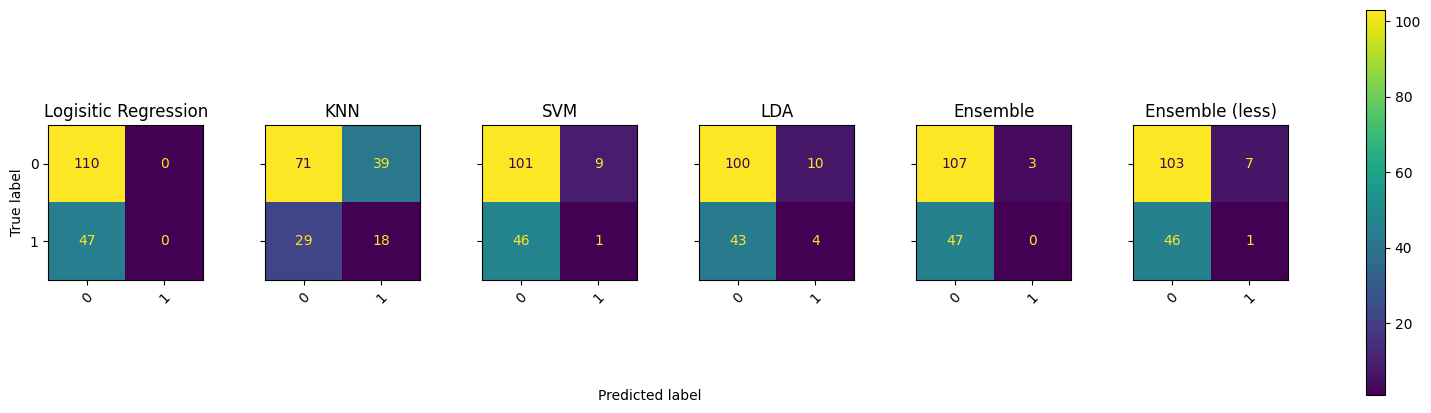

In [45]:
print_cmf(X_binary_train, y_binary_train)

In [46]:
print_predictions(X_binary_train_norm, y_binary_train)

Logistic Regression: 0.6496815286624203
KNN: 0.6369426751592356
SVM: 0.6751592356687898
LDA: 0.6624203821656051
Ensemble: 0.6624203821656051
Ensemble2: 0.6496815286624203


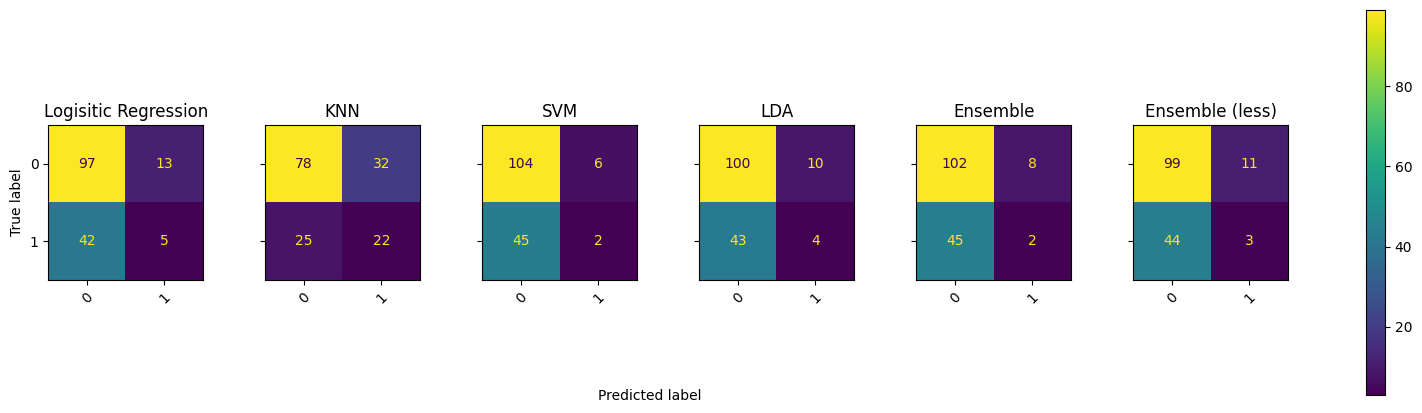

In [47]:
print_cmf(X_binary_train_norm, y_binary_train)

In [48]:
print_predictions(X_train, y_train)

Logistic Regression: 0.7006369426751592
KNN: 0.5668789808917197
SVM: 0.7006369426751592
LDA: 0.6496815286624203
Ensemble: 0.7006369426751592
Ensemble2: 0.7006369426751592


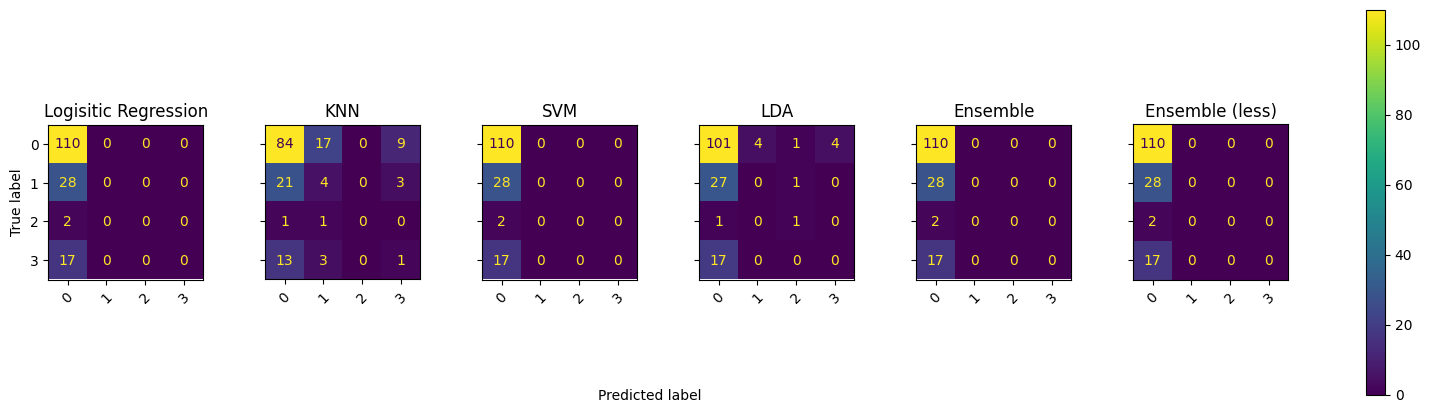

In [49]:
print_cmf(X_train, y_train)

In [50]:
print_predictions(X_train_norm, y_train)

Logistic Regression: 0.6496815286624203
KNN: 0.6050955414012739
SVM: 0.7006369426751592
LDA: 0.6496815286624203
Ensemble: 0.6815286624203821
Ensemble2: 0.6815286624203821


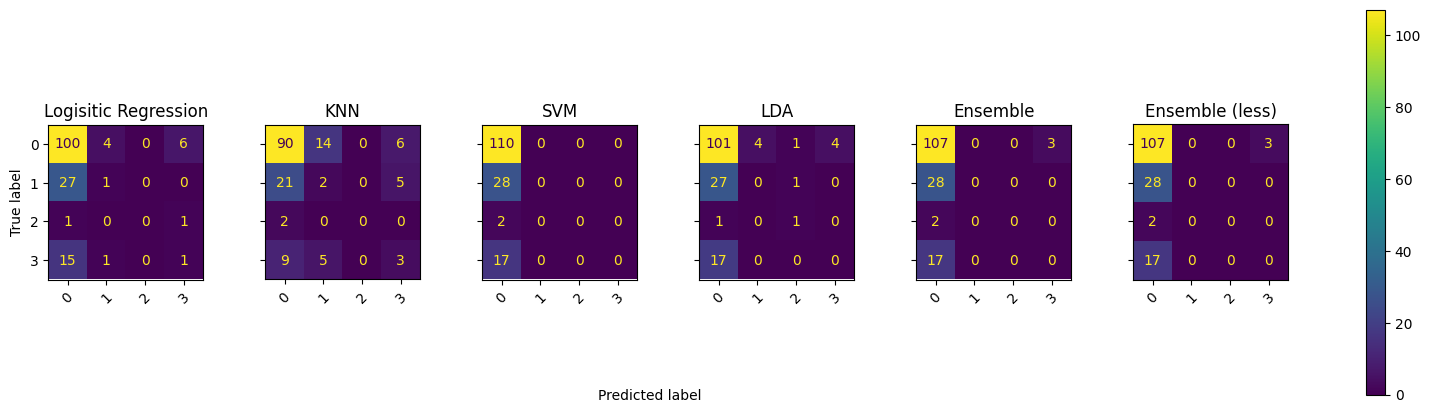

In [66]:
print_cmf(X_train_norm, y_train)